In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Create project folder in Drive
import os
os.makedirs('/content/drive/MyDrive/GI_Diffusion_Project', exist_ok=True)

print("✓ Google Drive mounted")
print("✓ All outputs will auto-save to Drive")

Mounted at /content/drive
✓ Google Drive mounted
✓ All outputs will auto-save to Drive


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zainitv/kvasir-gi-disease-4-classes-1000-each")

print("Path to dataset files:", path)

100%|██████████| 0.98G/0.98G [00:45<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1


In [3]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1


In [5]:
import os

base_path = "/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset"

for folder in os.listdir(base_path):
    print(folder)


ulcerative-colitis
esophagitis
polyps
normal-cecum


In [ ]:
import os

# Check dataset path
data_path = '/kaggle/input/kvasir-dataset'

# List contents
print("Contents of dataset folder:")
print(os.listdir(data_path))

Contents of dataset folder:
['kvasir-dataset']


In [ ]:
# Go deeper
data_path = '/kaggle/input/kvasir-dataset/kvasir-dataset'

print("Contents inside:")
folders = os.listdir(data_path)
print(folders)
print(f"\nTotal folders: {len(folders)}")

# Count images in each folder
print("\nImages per class:")
for folder in sorted(folders):
    folder_path = os.path.join(data_path, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        print(f"  {folder}: {num_images} images")

Contents inside:
['dyed-lifted-polyps', 'normal-z-line', 'dyed-resection-margins', 'normal-pylorus', 'normal-cecum', 'polyps', 'ulcerative-colitis', 'esophagitis']

Total folders: 8

Images per class:
  dyed-lifted-polyps: 500 images
  dyed-resection-margins: 500 images
  esophagitis: 500 images
  normal-cecum: 500 images
  normal-pylorus: 500 images
  normal-z-line: 500 images
  polyps: 500 images
  ulcerative-colitis: 500 images


In [ ]:
import os

# List all input datasets
print("Available datasets:")
print(os.listdir('/kaggle/input'))

Available datasets:
['kvasir-dataset', 'kvasir-gi-disease-4-classes-1000-each']


In [ ]:
# Check your uploaded dataset
data_path = '/kaggle/input/kvasir-gi-disease-4-classes-1000-each'

print("Contents:")
contents = os.listdir(data_path)
print(contents)

# If there's a subfolder, go deeper
if len(contents) == 1:
    inner_path = os.path.join(data_path, contents[0])
    print(f"\nInside {contents[0]}:")
    print(os.listdir(inner_path))

Contents:
['dataset']

Inside dataset:
['normal-cecum', 'polyps', 'ulcerative-colitis', 'esophagitis']


In [6]:
# Full path to classes
dataset_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'

print("Images per class:")
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images} images")

print(f"\nTotal images: {sum([len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)])}")

Images per class:
  ulcerative-colitis: 1000 images
  esophagitis: 1000 images
  polyps: 1000 images
  normal-cecum: 1000 images

Total images: 4000


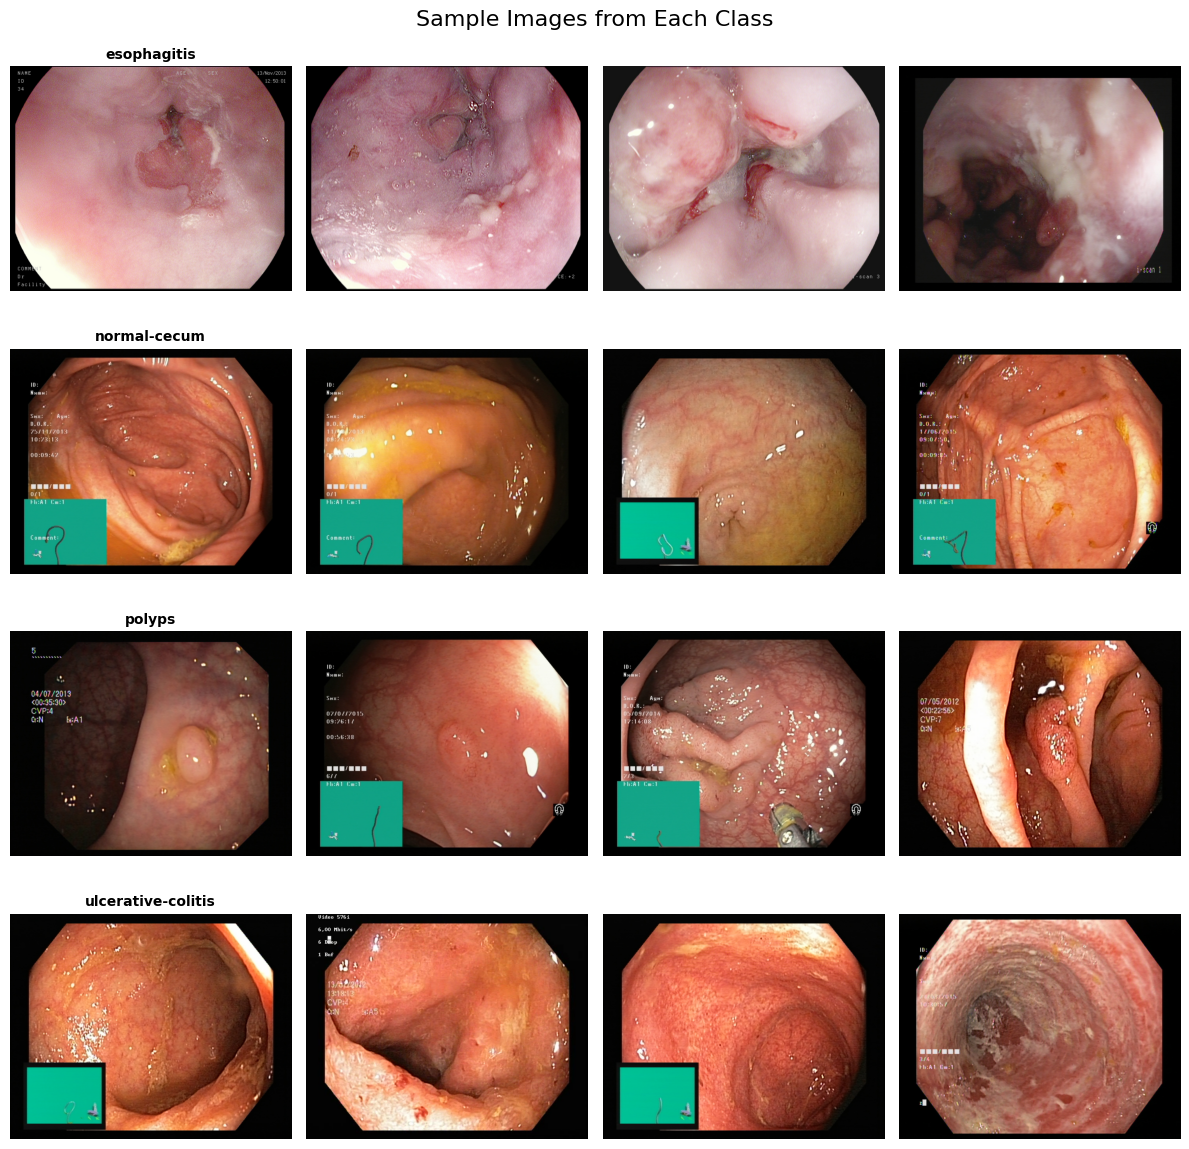

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import random

dataset_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'
classes = os.listdir(dataset_path)

# Visualize 4 samples from each class
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for i, cls in enumerate(sorted(classes)):
    cls_path = os.path.join(dataset_path, cls)
    images = os.listdir(cls_path)

    # Select 4 random images
    sample_images = random.sample(images, 4)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(cls_path, img_name)
        img = Image.open(img_path)

        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(cls, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Install diffusers library (Hugging Face)
!pip install -q diffusers[torch] accelerate

# Install other required libraries
!pip install -q transformers datasets

In [9]:
import torch
from diffusers import DDPMPipeline

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"\nDiffusers library imported successfully ✓")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.17 GB

Diffusers library imported successfully ✓


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class KvasirDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Get all image paths and labels
        self.images = []
        self.labels = []

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                self.images.append(os.path.join(cls_path, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms for diffusion (resize to 256x256, normalize to [-1, 1])
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

# Create dataset
dataset_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'
dataset = KvasirDataset(dataset_path, transform=transform)

print(f"Dataset size: {len(dataset)}")
print(f"Classes: {dataset.classes}")
print(f"Class mapping: {dataset.class_to_idx}")

Dataset size: 4000
Classes: ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']
Class mapping: {'esophagitis': 0, 'normal-cecum': 1, 'polyps': 2, 'ulcerative-colitis': 3}


In [ ]:
# # Create DataLoader
# batch_size = 16  # Good for 16GB GPU
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# print(f"Number of batches: {len(dataloader)}")
# print(f"Batch size: {batch_size}")

# # Test: Load one batch
# images, labels = next(iter(dataloader))
# print(f"\nBatch shape: {images.shape}")  # Should be [16, 3, 256, 256]
# print(f"Labels shape: {labels.shape}")   # Should be [16]
# print(f"Image range: [{images.min():.2f}, {images.max():.2f}]")  # Should be [-1, 1]

In [11]:
# Reduce batch size from 16 to 8
batch_size = 8

# Recreate dataloader with smaller batch
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"New batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

New batch size: 8
Number of batches: 500


In [12]:
from diffusers import UNet2DModel

# Create SMALLER U-Net (reduced channels)
model = UNet2DModel(
    sample_size=128,           # Reduced from 256 to 128
    in_channels=3,
    out_channels=3,
    layers_per_block=1,        # Reduced from 2 to 1
    block_out_channels=(64, 128, 256),  # Reduced from (128, 256, 512, 512)
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=4,
)

device = torch.device("cuda")
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"Model on: {next(model.parameters()).device}")

Model parameters: 10,127,811
Model on: cuda:0


In [13]:
from diffusers import DDPMScheduler

# Create noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

print(f"Scheduler: {type(noise_scheduler).__name__}")
print(f"Timesteps: {noise_scheduler.config.num_train_timesteps}")

Scheduler: DDPMScheduler
Timesteps: 1000


In [14]:
from torch.optim import AdamW
from torch.nn import functional as F

# Training configuration
num_epochs = 50  # Reduced from 100
learning_rate = 1e-4

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)
from tqdm.auto import tqdm

# Now redefine the training function with correct tqdm
def train_one_epoch(model, dataloader, optimizer, noise_scheduler, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        # Sample random timesteps
        batch_size = images.shape[0]
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()

        # Add noise to images
        noise = torch.randn_like(images)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        # Predict the noise
        noise_pred = model(noisy_images, timesteps, class_labels=labels).sample

        # Calculate loss
        loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    return avg_loss

print("✓ Optimizer and training function ready")
print(f"Epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")

✓ Optimizer and training function ready
Epochs: 50
Learning rate: 0.0001


# Training

In [15]:
print("Starting training...")
print(f"Batches per epoch: {len(dataloader)}")
print(f"Total epochs: {num_epochs}")
print("-" * 50)

losses = []

for epoch in range(num_epochs):
    avg_loss = train_one_epoch(model, dataloader, optimizer, noise_scheduler, device)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'diffusion_checkpoint_epoch_{epoch+1}.pth')
        print(f"  → Checkpoint saved!")

print("\n✓ Training completed!")

Starting training...
Batches per epoch: 500
Total epochs: 50
--------------------------------------------------


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/50 - Loss: 0.0742


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/50 - Loss: 0.0239


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/50 - Loss: 0.0170


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/50 - Loss: 0.0145


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/50 - Loss: 0.0137


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/50 - Loss: 0.0128


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/50 - Loss: 0.0124


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/50 - Loss: 0.0120


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/50 - Loss: 0.0117


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/50 - Loss: 0.0118
  → Checkpoint saved!


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/50 - Loss: 0.0109


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/50 - Loss: 0.0112


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/50 - Loss: 0.0112


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/50 - Loss: 0.0109


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/50 - Loss: 0.0109


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ 
   File "/usr/lib

Epoch 16/50 - Loss: 0.0104


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/50 - Loss: 0.0116


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/50 - Loss: 0.0103


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/50 - Loss: 0.0111


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/50 - Loss: 0.0099
  → Checkpoint saved!


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 21/50 - Loss: 0.0100


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 22/50 - Loss: 0.0096


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      ^^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ 
^  File "/us

Epoch 23/50 - Loss: 0.0101


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 24/50 - Loss: 0.0107


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 25/50 - Loss: 0.0104


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 26/50 - Loss: 0.0100


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 27/50 - Loss: 0.0096


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 28/50 - Loss: 0.0092


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 29/50 - Loss: 0.0098


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 30/50 - Loss: 0.0090
  → Checkpoint saved!


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 31/50 - Loss: 0.0090


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 32/50 - Loss: 0.0093


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 33/50 - Loss: 0.0099


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 34/50 - Loss: 0.0091


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 35/50 - Loss: 0.0095


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 36/50 - Loss: 0.0085


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 37/50 - Loss: 0.0095


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 38/50 - Loss: 0.0089


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbaa051ad40> 
 Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^^
^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^
^  File "/u

Epoch 39/50 - Loss: 0.0090


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 40/50 - Loss: 0.0091
  → Checkpoint saved!


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 41/50 - Loss: 0.0086


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 42/50 - Loss: 0.0087


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 43/50 - Loss: 0.0085


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 44/50 - Loss: 0.0091


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 45/50 - Loss: 0.0093


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 46/50 - Loss: 0.0086


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 47/50 - Loss: 0.0084


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 48/50 - Loss: 0.0089


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 49/50 - Loss: 0.0088


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 50/50 - Loss: 0.0101
  → Checkpoint saved!

✓ Training completed!


# Testing the Model

In [16]:
from diffusers import DDPMPipeline

# The model is already trained and in memory
print("✓ Using trained model")

# Function to generate images for a specific class
def generate_images(model, noise_scheduler, class_label, num_images=10, device='cuda'):
    model.eval()
    generated_images = []

    with torch.no_grad():
        for i in range(num_images):
            # Start with random noise
            image = torch.randn(1, 3, 128, 128).to(device)

            # Create class label tensor
            class_labels = torch.tensor([class_label]).to(device)

            # Denoise step by step
            for t in reversed(range(noise_scheduler.config.num_train_timesteps)):
                timestep = torch.tensor([t]).to(device)

                # Predict noise
                noise_pred = model(image, timestep, class_labels=class_labels).sample

                # Remove noise
                image = noise_scheduler.step(noise_pred, t, image).prev_sample

            generated_images.append(image)

    return torch.cat(generated_images, dim=0)

print("✓ Generation function ready")

✓ Using trained model
✓ Generation function ready


Generating synthetic images...
Generating esophagitis...
Generating normal-cecum...
Generating polyps...
Generating ulcerative-colitis...


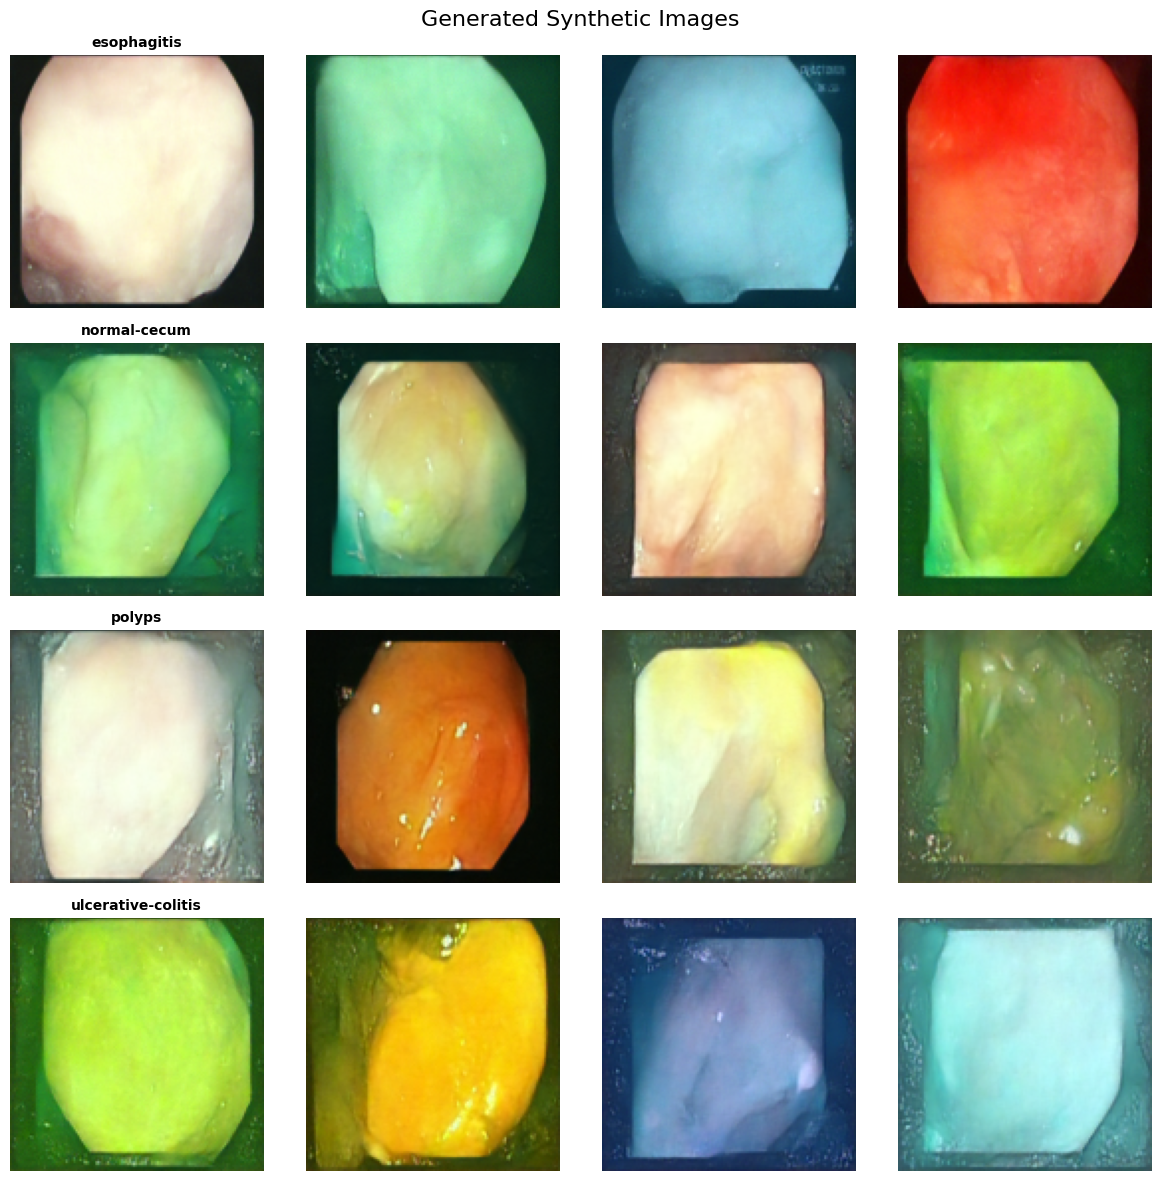


✓ Generation complete!


In [17]:
import matplotlib.pyplot as plt

# Class names
class_names = ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']

# Generate 4 images per class
print("Generating synthetic images...")
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Generated Synthetic Images', fontsize=16)

for class_idx, class_name in enumerate(class_names):
    print(f"Generating {class_name}...")

    # Generate 4 images for this class
    generated = generate_images(model, noise_scheduler, class_label=class_idx, num_images=4, device=device)

    # Convert from [-1, 1] to [0, 1] for display
    generated = (generated + 1) / 2
    generated = generated.cpu()

    # Display
    for i in range(4):
        img = generated[i].permute(1, 2, 0).numpy()
        axes[class_idx, i].imshow(img)
        axes[class_idx, i].axis('off')
        if i == 0:
            axes[class_idx, i].set_title(class_name, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Generation complete!")

# Generating Synthetic Data

In [18]:
import os
from PIL import Image as PILImage
import shutil
from google.colab import files

# Create output directories (both in Colab and Google Drive)
colab_path = '/content/synthetic_images'
drive_path = '/content/drive/MyDrive/GI_Diffusion_Project/synthetic_images'

os.makedirs(colab_path, exist_ok=True)
os.makedirs(drive_path, exist_ok=True)

# Generate 100 images per class
num_images_per_class = 100

for class_idx, class_name in enumerate(class_names):
    print(f"Generating {num_images_per_class} images for {class_name}...")

    # Create class folders in both locations
    colab_class_folder = f'{colab_path}/{class_name}'
    drive_class_folder = f'{drive_path}/{class_name}'
    os.makedirs(colab_class_folder, exist_ok=True)
    os.makedirs(drive_class_folder, exist_ok=True)

    # Generate in batches of 10 to avoid memory issues
    for batch in range(10):  # 10 batches × 10 images = 100
        generated = generate_images(model, noise_scheduler, class_label=class_idx, num_images=10, device=device)

        # Convert and save
        generated = (generated + 1) / 2  # [-1, 1] to [0, 1]
        generated = generated.cpu()

        for i in range(10):
            img = generated[i].permute(1, 2, 0).numpy()
            img = (img * 255).astype('uint8')
            img_pil = PILImage.fromarray(img)

            filename = f'synthetic_{batch * 10 + i:04d}.jpg'

            # Save to Colab
            img_pil.save(f'{colab_class_folder}/{filename}')

            # Save to Google Drive (auto-backup)
            img_pil.save(f'{drive_class_folder}/{filename}')

    print(f"  ✓ Saved 100 images for {class_name}")

print("\n✓ All synthetic images saved!")
print(f"Colab location: {colab_path}")
print(f"Google Drive location: {drive_path} (permanent backup)")

# Create zip for direct download
print("\nCreating ZIP for download...")
shutil.make_archive('/content/synthetic_images_download', 'zip', colab_path)

print("✓ ZIP created! Downloading to your laptop...")
files.download('/content/synthetic_images_download.zip')

print("\n✅ COMPLETE! Images saved in 3 places:")
print("  1. Colab: /content/synthetic_images/")
print("  2. Google Drive: Auto-synced")
print("  3. Your laptop: synthetic_images_download.zip downloaded")

Generating 100 images for esophagitis...
  ✓ Saved 100 images for esophagitis
Generating 100 images for normal-cecum...
  ✓ Saved 100 images for normal-cecum
Generating 100 images for polyps...
  ✓ Saved 100 images for polyps
Generating 100 images for ulcerative-colitis...
  ✓ Saved 100 images for ulcerative-colitis

✓ All synthetic images saved!
Colab location: /content/synthetic_images
Google Drive location: /content/drive/MyDrive/GI_Diffusion_Project/synthetic_images (permanent backup)

Creating ZIP for download...
✓ ZIP created! Downloading to your laptop...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPLETE! Images saved in 3 places:
  1. Colab: /content/synthetic_images/
  2. Google Drive: Auto-synced
  3. Your laptop: synthetic_images_download.zip downloaded


In [19]:
# Create combined dataset (real + synthetic)
import shutil
from google.colab import files

# Define paths for Colab
real_data_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'
synthetic_data_path = '/content/synthetic_images'
combined_data_path = '/content/combined_dataset'
drive_combined_path = '/content/drive/MyDrive/GI_Diffusion_Project/combined_dataset'

# Create directories
os.makedirs(combined_data_path, exist_ok=True)
os.makedirs(drive_combined_path, exist_ok=True)

for class_name in class_names:
    # Create class folders
    combined_class_path = os.path.join(combined_data_path, class_name)
    drive_class_path = os.path.join(drive_combined_path, class_name)
    os.makedirs(combined_class_path, exist_ok=True)
    os.makedirs(drive_class_path, exist_ok=True)

    # Copy real images
    real_class_path = os.path.join(real_data_path, class_name)
    real_images = os.listdir(real_class_path)

    for img in real_images:
        src = os.path.join(real_class_path, img)
        dst_colab = os.path.join(combined_class_path, f'real_{img}')
        dst_drive = os.path.join(drive_class_path, f'real_{img}')

        shutil.copy(src, dst_colab)
        shutil.copy(src, dst_drive)

    # Copy synthetic images
    synthetic_class_path = os.path.join(synthetic_data_path, class_name)
    synthetic_images = os.listdir(synthetic_class_path)

    for img in synthetic_images:
        src = os.path.join(synthetic_class_path, img)
        dst_colab = os.path.join(combined_class_path, f'synthetic_{img}')
        dst_drive = os.path.join(drive_class_path, f'synthetic_{img}')

        shutil.copy(src, dst_colab)
        shutil.copy(src, dst_drive)

    print(f"{class_name}: {len(real_images)} real + {len(synthetic_images)} synthetic = {len(real_images) + len(synthetic_images)} total")

print("\n✓ Combined dataset created in Colab!")
print("✓ Combined dataset backed up to Google Drive!")

# Create ZIP for download
# print("\nCreating ZIP for download...")
# shutil.make_archive('/content/combined_dataset_download', 'zip', combined_data_path)

# print("✓ Downloading combined dataset to your laptop...")
# files.download('/content/combined_dataset_download.zip')

print("\n✅ COMPLETE! Combined dataset saved in 2 places:")
print(f"  1. Colab: {combined_data_path}")
print(f"  2. Google Drive: {drive_combined_path}")
# print("  3. Your laptop: combined_dataset_download.zip downloaded")

esophagitis: 1000 real + 100 synthetic = 1100 total
normal-cecum: 1000 real + 100 synthetic = 1100 total
polyps: 1000 real + 100 synthetic = 1100 total
ulcerative-colitis: 1000 real + 100 synthetic = 1100 total

✓ Combined dataset created in Colab!
✓ Combined dataset backed up to Google Drive!

Creating ZIP for download...
✓ Downloading combined dataset to your laptop...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPLETE! Combined dataset saved in 3 places:
  1. Colab: /content/combined_dataset
  2. Google Drive: /content/drive/MyDrive/GI_Diffusion_Project/combined_dataset
  3. Your laptop: combined_dataset_download.zip downloaded


In [20]:
!pip install -q timm

import timm
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

print("✓ timm installed")

# Create datasets for baseline and proposed
baseline_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Update paths for Colab
real_data_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'
combined_data_path = '/content/combined_dataset'

# Baseline dataset (real only)
baseline_dataset = KvasirDataset(real_data_path, transform=baseline_transform)

# Proposed dataset (real + synthetic)
proposed_dataset = KvasirDataset(combined_data_path, transform=baseline_transform)

print(f"Baseline dataset: {len(baseline_dataset)} images")
print(f"Proposed dataset: {len(proposed_dataset)} images")

# Split into train/val/test (70/15/15)
def create_splits(dataset):
    indices = list(range(len(dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)

    return train_set, val_set, test_set

baseline_train, baseline_val, baseline_test = create_splits(baseline_dataset)
proposed_train, proposed_val, proposed_test = create_splits(proposed_dataset)

print(f"\nBaseline - Train: {len(baseline_train)}, Val: {len(baseline_val)}, Test: {len(baseline_test)}")
print(f"Proposed - Train: {len(proposed_train)}, Val: {len(proposed_val)}, Test: {len(proposed_test)}")

✓ timm installed
Baseline dataset: 4000 images
Proposed dataset: 4400 images

Baseline - Train: 2800, Val: 600, Test: 600
Proposed - Train: 3080, Val: 660, Test: 660


In [21]:
import timm
from torch import nn

class GIClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        self.classifier = nn.Sequential(
            nn.Linear(1536, 512),  # EfficientNet-B3 outputs 1536 features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Training function with auto-save to Drive
def train_classifier(model, train_loader, val_loader, epochs=30, lr=1e-4, device='cuda', save_name='classifier'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save to both Colab and Drive
            torch.save(model.state_dict(), f'/content/best_{save_name}.pth')
            torch.save(model.state_dict(), f'/content/drive/MyDrive/GI_Diffusion_Project/best_{save_name}.pth')
            print(f"  → Checkpoint saved! (Acc: {val_acc:.2f}%)")

    return train_losses, val_losses, val_accs, best_val_acc

print("✓ Classifier and training function defined")

✓ Classifier and training function defined


In [22]:
# Create dataloaders for baseline
baseline_train_loader = DataLoader(baseline_train, batch_size=32, shuffle=True, num_workers=2)
baseline_val_loader = DataLoader(baseline_val, batch_size=32, shuffle=False, num_workers=2)
baseline_test_loader = DataLoader(baseline_test, batch_size=32, shuffle=False, num_workers=2)

print("="*60)
print("TRAINING BASELINE MODEL (Real Images Only)")
print("="*60)

baseline_model = GIClassifier(num_classes=4)
baseline_train_losses, baseline_val_losses, baseline_val_accs, baseline_best_acc = train_classifier(
    baseline_model,
    baseline_train_loader,
    baseline_val_loader,
    epochs=30,
    device=device,
    save_name='baseline_classifier'  # Added this
)

print(f"\n✓ Baseline Best Validation Accuracy: {baseline_best_acc:.2f}%")

TRAINING BASELINE MODEL (Real Images Only)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Epoch 1/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.7372, Val Loss: 0.4314, Val Acc: 96.67%
  → Checkpoint saved! (Acc: 96.67%)


Epoch 2/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.4215, Val Loss: 0.4073, Val Acc: 98.00%
  → Checkpoint saved! (Acc: 98.00%)


Epoch 3/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.3914, Val Loss: 0.3965, Val Acc: 98.00%


Epoch 4/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.3832, Val Loss: 0.4096, Val Acc: 97.33%


Epoch 5/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3737, Val Loss: 0.4058, Val Acc: 98.00%


Epoch 6/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3653, Val Loss: 0.4183, Val Acc: 97.00%


Epoch 7/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3684, Val Loss: 0.4088, Val Acc: 97.67%


Epoch 8/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3642, Val Loss: 0.4036, Val Acc: 97.67%


Epoch 9/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3627, Val Loss: 0.3934, Val Acc: 98.17%
  → Checkpoint saved! (Acc: 98.17%)


Epoch 10/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.3613, Val Loss: 0.3973, Val Acc: 97.33%


Epoch 11/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.3570, Val Loss: 0.4021, Val Acc: 97.67%


Epoch 12/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.3593, Val Loss: 0.4002, Val Acc: 97.83%


Epoch 13/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.3567, Val Loss: 0.4098, Val Acc: 96.67%


Epoch 14/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.3547, Val Loss: 0.3943, Val Acc: 97.67%


Epoch 15/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.3542, Val Loss: 0.3948, Val Acc: 97.67%


Epoch 16/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.3531, Val Loss: 0.3985, Val Acc: 97.83%


Epoch 17/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.3537, Val Loss: 0.4071, Val Acc: 97.33%


Epoch 18/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.3525, Val Loss: 0.3921, Val Acc: 98.17%


Epoch 19/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.3544, Val Loss: 0.3996, Val Acc: 97.50%


Epoch 20/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.3529, Val Loss: 0.4027, Val Acc: 97.50%


Epoch 21/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.3533, Val Loss: 0.3955, Val Acc: 97.83%


Epoch 22/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.3537, Val Loss: 0.4002, Val Acc: 98.00%


Epoch 23/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.3549, Val Loss: 0.4040, Val Acc: 97.83%


Epoch 24/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.3533, Val Loss: 0.4022, Val Acc: 97.17%


Epoch 25/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.3523, Val Loss: 0.3977, Val Acc: 97.67%


Epoch 26/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.3536, Val Loss: 0.4513, Val Acc: 95.50%


Epoch 27/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.3532, Val Loss: 0.4155, Val Acc: 97.33%


Epoch 28/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.3551, Val Loss: 0.3927, Val Acc: 98.33%
  → Checkpoint saved! (Acc: 98.33%)


Epoch 29/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.3531, Val Loss: 0.3856, Val Acc: 98.83%
  → Checkpoint saved! (Acc: 98.83%)


Epoch 30/30:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.3522, Val Loss: 0.3878, Val Acc: 98.00%

✓ Baseline Best Validation Accuracy: 98.83%


In [24]:
# Create dataloaders for proposed (real + synthetic)
proposed_train_loader = DataLoader(proposed_train, batch_size=32, shuffle=True, num_workers=2)
proposed_val_loader = DataLoader(proposed_val, batch_size=32, shuffle=False, num_workers=2)
proposed_test_loader = DataLoader(proposed_test, batch_size=32, shuffle=False, num_workers=2)

print("="*60)
print("TRAINING PROPOSED MODEL (Real + Synthetic Images)")
print("="*60)

proposed_model = GIClassifier(num_classes=4)
proposed_train_losses, proposed_val_losses, proposed_val_accs, proposed_best_acc = train_classifier(
    proposed_model,
    proposed_train_loader,
    proposed_val_loader,
    epochs=30,
    device=device,
    save_name='proposed_classifier'
)

print(f"\n✓ Proposed Best Validation Accuracy: {proposed_best_acc:.2f}%")

# Compare results
print("\n" + "="*60)
print("COMPARISON")
print("="*60)
print(f"Baseline (Real only):        {baseline_best_acc:.2f}%")
print(f"Proposed (Real + Synthetic): {proposed_best_acc:.2f}%")
print(f"Improvement:                 {proposed_best_acc - baseline_best_acc:+.2f}%")
print("="*60)

TRAINING PROPOSED MODEL (Real + Synthetic Images)


Epoch 1/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.7786, Val Loss: 0.4740, Val Acc: 94.39%
  → Checkpoint saved! (Acc: 94.39%)


Epoch 2/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.4814, Val Loss: 0.4514, Val Acc: 95.15%
  → Checkpoint saved! (Acc: 95.15%)


Epoch 3/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4351, Val Loss: 0.4414, Val Acc: 95.45%
  → Checkpoint saved! (Acc: 95.45%)


Epoch 4/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.4019, Val Loss: 0.4404, Val Acc: 94.70%


Epoch 5/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.3894, Val Loss: 0.4308, Val Acc: 96.82%
  → Checkpoint saved! (Acc: 96.82%)


Epoch 6/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3844, Val Loss: 0.4440, Val Acc: 95.45%


Epoch 7/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3733, Val Loss: 0.4326, Val Acc: 96.36%


Epoch 8/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3656, Val Loss: 0.4325, Val Acc: 96.21%


Epoch 9/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3651, Val Loss: 0.4387, Val Acc: 96.06%


Epoch 10/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.3650, Val Loss: 0.4690, Val Acc: 94.24%


Epoch 11/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.3687, Val Loss: 0.4613, Val Acc: 94.85%


Epoch 12/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.3601, Val Loss: 0.4380, Val Acc: 95.76%


Epoch 13/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.3606, Val Loss: 0.4479, Val Acc: 95.45%


Epoch 14/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.3576, Val Loss: 0.4387, Val Acc: 96.52%


Epoch 15/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.3602, Val Loss: 0.4428, Val Acc: 95.30%


Epoch 16/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.3579, Val Loss: 0.4520, Val Acc: 95.15%


Epoch 17/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.3545, Val Loss: 0.4429, Val Acc: 95.76%


Epoch 18/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.3551, Val Loss: 0.4459, Val Acc: 95.61%


Epoch 19/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.3557, Val Loss: 0.4400, Val Acc: 96.06%


Epoch 20/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.3562, Val Loss: 0.4457, Val Acc: 95.15%


Epoch 21/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.3550, Val Loss: 0.4500, Val Acc: 95.30%


Epoch 22/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.3537, Val Loss: 0.4431, Val Acc: 95.91%


Epoch 23/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.3538, Val Loss: 0.4474, Val Acc: 95.61%


Epoch 24/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.3540, Val Loss: 0.4424, Val Acc: 95.76%


Epoch 25/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.3559, Val Loss: 0.4353, Val Acc: 95.91%


Epoch 26/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.3533, Val Loss: 0.4421, Val Acc: 95.45%


Epoch 27/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.3533, Val Loss: 0.4298, Val Acc: 96.52%


Epoch 28/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.3559, Val Loss: 0.4541, Val Acc: 94.85%


Epoch 29/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.3569, Val Loss: 0.4489, Val Acc: 95.45%


Epoch 30/30:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.3536, Val Loss: 0.4470, Val Acc: 95.30%

✓ Proposed Best Validation Accuracy: 96.82%

COMPARISON
Baseline (Real only):        98.83%
Proposed (Real + Synthetic): 96.82%
Improvement:                 -2.02%


In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100. * correct / total
    return test_acc, all_preds, all_labels

# Load best models
baseline_model.load_state_dict(torch.load('/content/best_baseline_classifier.pth'))
proposed_model.load_state_dict(torch.load('/content/best_proposed_classifier.pth'))

print("="*60)
print("TEST SET EVALUATION")
print("="*60)

# Baseline test
baseline_test_acc, baseline_preds, baseline_labels = evaluate_model(baseline_model, baseline_test_loader, device)
print(f"\nBaseline Test Accuracy: {baseline_test_acc:.2f}%")

# Proposed test
proposed_test_acc, proposed_preds, proposed_labels = evaluate_model(proposed_model, proposed_test_loader, device)
print(f"Proposed Test Accuracy: {proposed_test_acc:.2f}%")

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Baseline - Val: {baseline_best_acc:.2f}%, Test: {baseline_test_acc:.2f}%")
print(f"Proposed - Val: {proposed_best_acc:.2f}%, Test: {proposed_test_acc:.2f}%")
print("="*60)

# Classification reports
class_names = ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']

print("\n📊 BASELINE Classification Report:")
print(classification_report(baseline_labels, baseline_preds, target_names=class_names, digits=4))

print("\n📊 PROPOSED Classification Report:")
print(classification_report(proposed_labels, proposed_preds, target_names=class_names, digits=4))

TEST SET EVALUATION


Testing:   0%|          | 0/19 [00:00<?, ?it/s]


Baseline Test Accuracy: 98.33%


Testing:   0%|          | 0/21 [00:00<?, ?it/s]

Proposed Test Accuracy: 94.24%

FINAL RESULTS SUMMARY
Baseline - Val: 98.83%, Test: 98.33%
Proposed - Val: 96.82%, Test: 94.24%

📊 BASELINE Classification Report:
                    precision    recall  f1-score   support

       esophagitis     1.0000    1.0000    1.0000       167
      normal-cecum     0.9809    0.9872    0.9840       156
            polyps     0.9704    0.9704    0.9704       135
ulcerative-colitis     0.9787    0.9718    0.9753       142

          accuracy                         0.9833       600
         macro avg     0.9825    0.9823    0.9824       600
      weighted avg     0.9833    0.9833    0.9833       600


📊 PROPOSED Classification Report:
                    precision    recall  f1-score   support

       esophagitis     0.9943    1.0000    0.9971       174
      normal-cecum     0.9245    0.9130    0.9187       161
            polyps     0.9355    0.9119    0.9236       159
ulcerative-colitis     0.9123    0.9398    0.9258       166

          accurac

In [29]:
import os
from PIL import Image as PILImage
import shutil
from google.colab import files

# Create output directories (Colab + Google Drive)
colab_path = '/content/synthetic_images'
drive_path = '/content/drive/MyDrive/GI_Diffusion_Project/synthetic_images'

os.makedirs(colab_path, exist_ok=True)
os.makedirs(drive_path, exist_ok=True)

# We want: synthetic_0100.jpg → synthetic_0299.jpg
start_index = 100
num_images_per_class = 200  # 200 images per class
batch_size = 10             # generate 10 at a time
num_batches = num_images_per_class // batch_size  # 20 batches

for class_idx, class_name in enumerate(class_names):
    print(f"Generating {num_images_per_class} images for {class_name}...")

    # Create class folders in both locations
    colab_class_folder = f'{colab_path}/{class_name}'
    drive_class_folder = f'{drive_path}/{class_name}'
    os.makedirs(colab_class_folder, exist_ok=True)
    os.makedirs(drive_class_folder, exist_ok=True)

    # Generate true 200 images
    for batch in range(num_batches):  # 20 batches × 10 images = 200
        generated = generate_images(model, noise_scheduler, class_label=class_idx, num_images=batch_size, device=device)

        generated = (generated + 1) / 2
        generated = generated.cpu()

        for i in range(batch_size):
            img = generated[i].permute(1, 2, 0).numpy()
            img = (img * 255).astype('uint8')
            img_pil = PILImage.fromarray(img)

            # Correct naming: 0100 → 0299
            file_index = start_index + batch * batch_size + i
            filename = f"synthetic_{file_index:04d}.jpg"

            # Save both copies
            img_pil.save(f'{colab_class_folder}/{filename}')
            img_pil.save(f'{drive_class_folder}/{filename}')

    print(f"  ✓ Saved 200 images for {class_name}")

print("\n✓ All synthetic images saved!")
print(f"Colab location: {colab_path}")
print(f"Google Drive location: {drive_path}")

# Create ZIP for download
print("\nCreating ZIP for download...")
shutil.make_archive('/content/synthetic_images_download', 'zip', colab_path)

print("✓ ZIP created! Downloading...")
files.download('/content/synthetic_images_download.zip')

print("\n✅ COMPLETE!")


Generating 200 images for esophagitis...
  ✓ Saved 200 images for esophagitis
Generating 200 images for normal-cecum...
  ✓ Saved 200 images for normal-cecum
Generating 200 images for polyps...
  ✓ Saved 200 images for polyps
Generating 200 images for ulcerative-colitis...
  ✓ Saved 200 images for ulcerative-colitis

✓ All synthetic images saved!
Colab location: /content/synthetic_images
Google Drive location: /content/drive/MyDrive/GI_Diffusion_Project/synthetic_images

Creating ZIP for download...
✓ ZIP created! Downloading...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ COMPLETE!


In [30]:
import shutil
import os

# Paths
synthetic_data_path = '/content/synthetic_images'
combined_data_path = '/content/combined_dataset'  # Existing one
drive_combined_path = '/content/drive/MyDrive/GI_Diffusion_Project/combined_dataset'

class_names = ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']

for class_name in class_names:
    combined_class_path = os.path.join(combined_data_path, class_name)
    drive_class_path = os.path.join(drive_combined_path, class_name)

    # Get only NEW synthetic images (100-299)
    synthetic_class_path = os.path.join(synthetic_data_path, class_name)
    all_synthetic = os.listdir(synthetic_class_path)

    # Filter for images 100-299
    new_synthetic = [f for f in all_synthetic if f.startswith('synthetic_01') or f.startswith('synthetic_02')]

    print(f"Adding {len(new_synthetic)} new images to {class_name}...")

    for img in new_synthetic:
        src = os.path.join(synthetic_class_path, img)
        dst_colab = os.path.join(combined_class_path, f'synthetic_{img}')
        dst_drive = os.path.join(drive_class_path, f'synthetic_{img}')

        shutil.copy(src, dst_colab)
        shutil.copy(src, dst_drive)

    # Count total now
    total = len(os.listdir(combined_class_path))
    print(f"  → {class_name} now has {total} total images")

print("\n✓ New synthetic images added to existing combined dataset!")

Adding 200 new images to esophagitis...
  → esophagitis now has 1300 total images
Adding 200 new images to normal-cecum...
  → normal-cecum now has 1300 total images
Adding 200 new images to polyps...
  → polyps now has 1300 total images
Adding 200 new images to ulcerative-colitis...
  → ulcerative-colitis now has 1300 total images

✓ New synthetic images added to existing combined dataset!


In [31]:
# Full path to classes
dataset_path = '/content/combined_dataset'

print("Images per class:")
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(cls_path))
    print(f"  {cls}: {num_images} images")

print(f"\nTotal images: {sum([len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)])}")

Images per class:
  ulcerative-colitis: 1300 images
  esophagitis: 1300 images
  polyps: 1300 images
  normal-cecum: 1300 images

Total images: 5200


In [32]:
# Recreate proposed dataset with updated combined_dataset
proposed_dataset_v2 = KvasirDataset(combined_data_path, transform=baseline_transform)

print(f"Updated Proposed dataset: {len(proposed_dataset_v2)} images")

# Create new splits
proposed_train_v2, proposed_val_v2, proposed_test_v2 = create_splits(proposed_dataset_v2)

print(f"Proposed v2 - Train: {len(proposed_train_v2)}, Val: {len(proposed_val_v2)}, Test: {len(proposed_test_v2)}")

# Create dataloaders
proposed_train_loader_v2 = DataLoader(proposed_train_v2, batch_size=32, shuffle=True, num_workers=2)
proposed_val_loader_v2 = DataLoader(proposed_val_v2, batch_size=32, shuffle=False, num_workers=2)
proposed_test_loader_v2 = DataLoader(proposed_test_v2, batch_size=32, shuffle=False, num_workers=2)

print("\n" + "="*60)
print("TRAINING PROPOSED V2 MODEL (Real + 300 Synthetic per class)")
print("="*60)

proposed_model_v2 = GIClassifier(num_classes=4)
proposed_train_losses_v2, proposed_val_losses_v2, proposed_val_accs_v2, proposed_best_acc_v2 = train_classifier(
    proposed_model_v2,
    proposed_train_loader_v2,
    proposed_val_loader_v2,
    epochs=30,
    device=device,
    save_name='proposed_v2_classifier'
)

print(f"\n✓ Proposed V2 Best Validation Accuracy: {proposed_best_acc_v2:.2f}%")

# Final comparison
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)
print(f"Baseline (4,000 real):              {baseline_best_acc:.2f}%")
print(f"Proposed V1 (4,000 + 400 synthetic): {proposed_best_acc:.2f}%")
print(f"Proposed V2 (4,000 + 1,200 synthetic): {proposed_best_acc_v2:.2f}%")
print(f"V2 vs Baseline:                     {proposed_best_acc_v2 - baseline_best_acc:+.2f}%")
print("="*60)

Updated Proposed dataset: 5200 images
Proposed v2 - Train: 3640, Val: 780, Test: 780

TRAINING PROPOSED V2 MODEL (Real + 300 Synthetic per class)


Epoch 1/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.8070, Val Loss: 0.5341, Val Acc: 89.49%
  → Checkpoint saved! (Acc: 89.49%)


Epoch 2/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.5238, Val Loss: 0.4988, Val Acc: 92.95%
  → Checkpoint saved! (Acc: 92.95%)


Epoch 3/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.4575, Val Loss: 0.5063, Val Acc: 91.92%


Epoch 4/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.4225, Val Loss: 0.4821, Val Acc: 92.18%


Epoch 5/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.4024, Val Loss: 0.5018, Val Acc: 91.92%


Epoch 6/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.3956, Val Loss: 0.4778, Val Acc: 92.69%


Epoch 7/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.3838, Val Loss: 0.5046, Val Acc: 92.05%


Epoch 8/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.3718, Val Loss: 0.4861, Val Acc: 92.69%


Epoch 9/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.3734, Val Loss: 0.4789, Val Acc: 93.08%
  → Checkpoint saved! (Acc: 93.08%)


Epoch 10/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.3643, Val Loss: 0.4868, Val Acc: 93.46%
  → Checkpoint saved! (Acc: 93.46%)


Epoch 11/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.3666, Val Loss: 0.4797, Val Acc: 93.21%


Epoch 12/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.3661, Val Loss: 0.4805, Val Acc: 92.95%


Epoch 13/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.3650, Val Loss: 0.4905, Val Acc: 92.56%


Epoch 14/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.3620, Val Loss: 0.4915, Val Acc: 92.95%


Epoch 15/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.3577, Val Loss: 0.4981, Val Acc: 92.31%


Epoch 16/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.3612, Val Loss: 0.5003, Val Acc: 92.18%


Epoch 17/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.3618, Val Loss: 0.4893, Val Acc: 92.95%


Epoch 18/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.3591, Val Loss: 0.5153, Val Acc: 92.56%


Epoch 19/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.3586, Val Loss: 0.5313, Val Acc: 91.67%


Epoch 20/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.3649, Val Loss: 0.5219, Val Acc: 91.67%


Epoch 21/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.3591, Val Loss: 0.5140, Val Acc: 92.56%


Epoch 22/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.3564, Val Loss: 0.4977, Val Acc: 93.08%


Epoch 23/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.3535, Val Loss: 0.5070, Val Acc: 91.92%


Epoch 24/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.3567, Val Loss: 0.4997, Val Acc: 92.31%


Epoch 25/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.3581, Val Loss: 0.4993, Val Acc: 92.31%


Epoch 26/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.3572, Val Loss: 0.4890, Val Acc: 93.21%


Epoch 27/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 27: Train Loss: 0.3556, Val Loss: 0.5207, Val Acc: 92.05%


Epoch 28/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 28: Train Loss: 0.3567, Val Loss: 0.4992, Val Acc: 92.82%


Epoch 29/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 29: Train Loss: 0.3553, Val Loss: 0.5001, Val Acc: 92.95%


Epoch 30/30:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 30: Train Loss: 0.3544, Val Loss: 0.4877, Val Acc: 93.59%
  → Checkpoint saved! (Acc: 93.59%)

✓ Proposed V2 Best Validation Accuracy: 93.59%

FINAL COMPARISON
Baseline (4,000 real):              98.83%
Proposed V1 (4,000 + 400 synthetic): 96.82%
Proposed V2 (4,000 + 1,200 synthetic): 93.59%
V2 vs Baseline:                     -5.24%


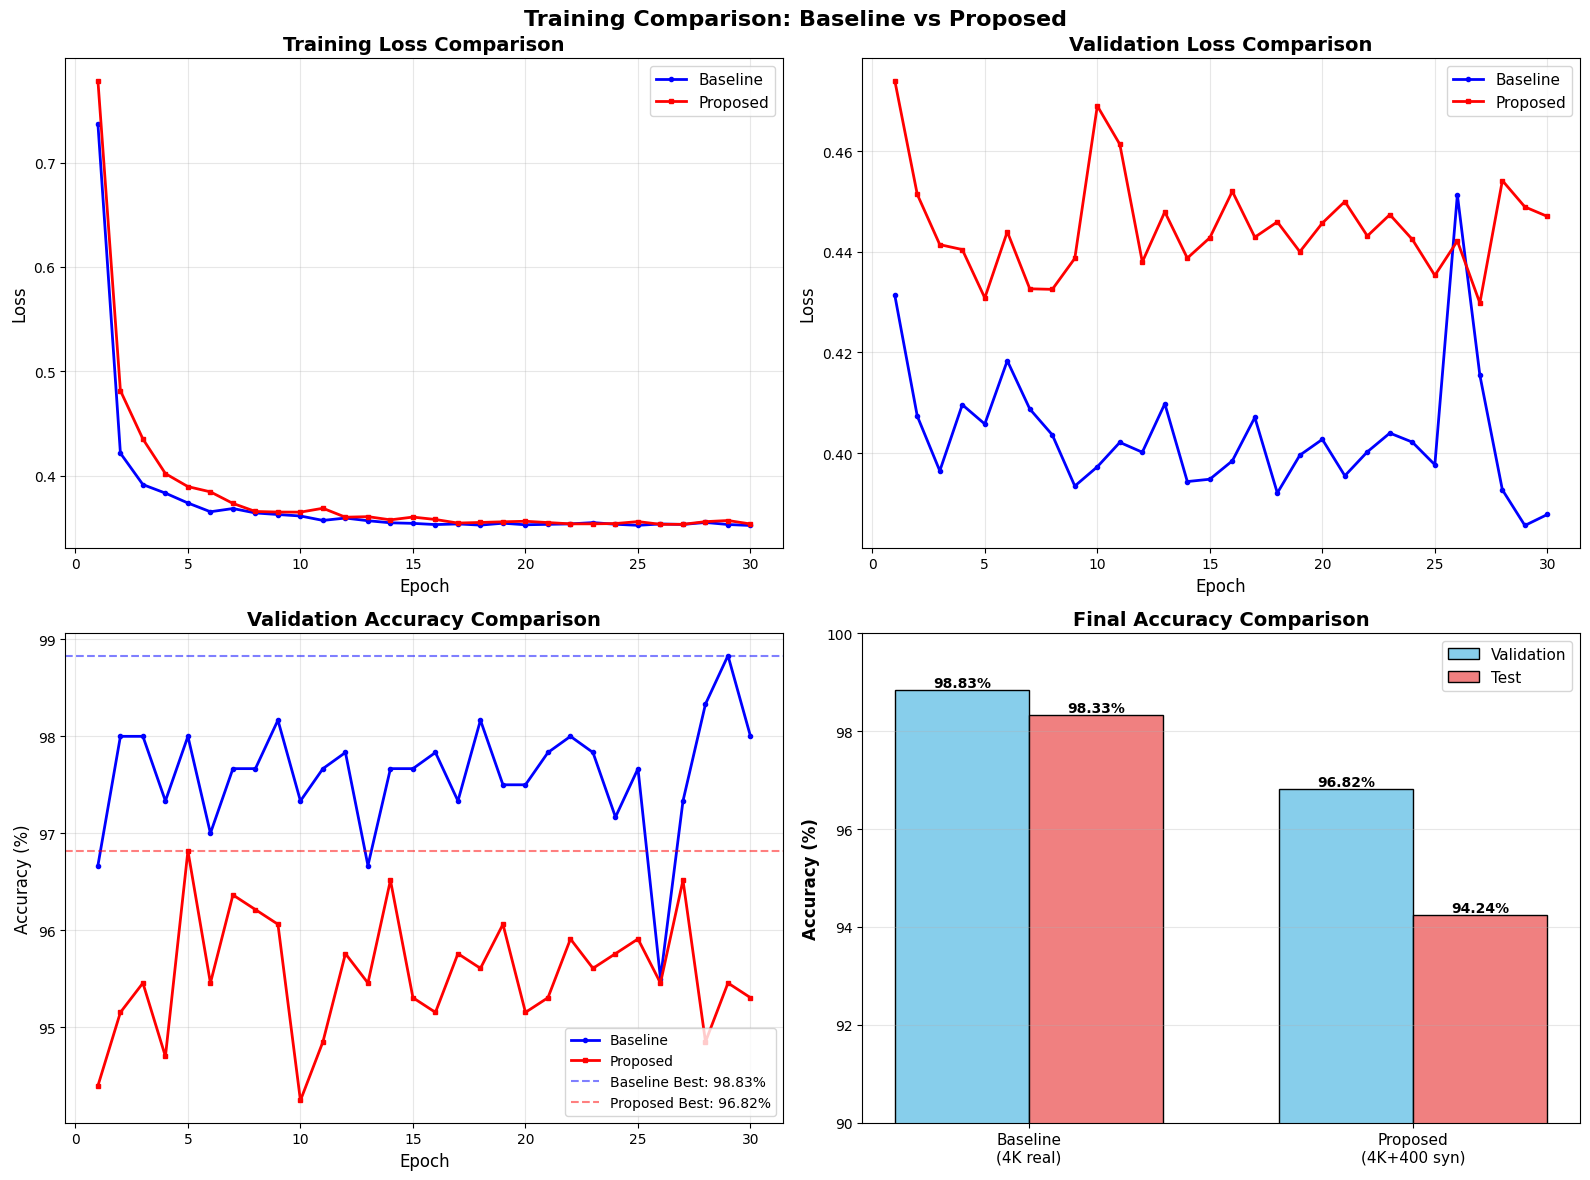

✓ Training comparison saved!


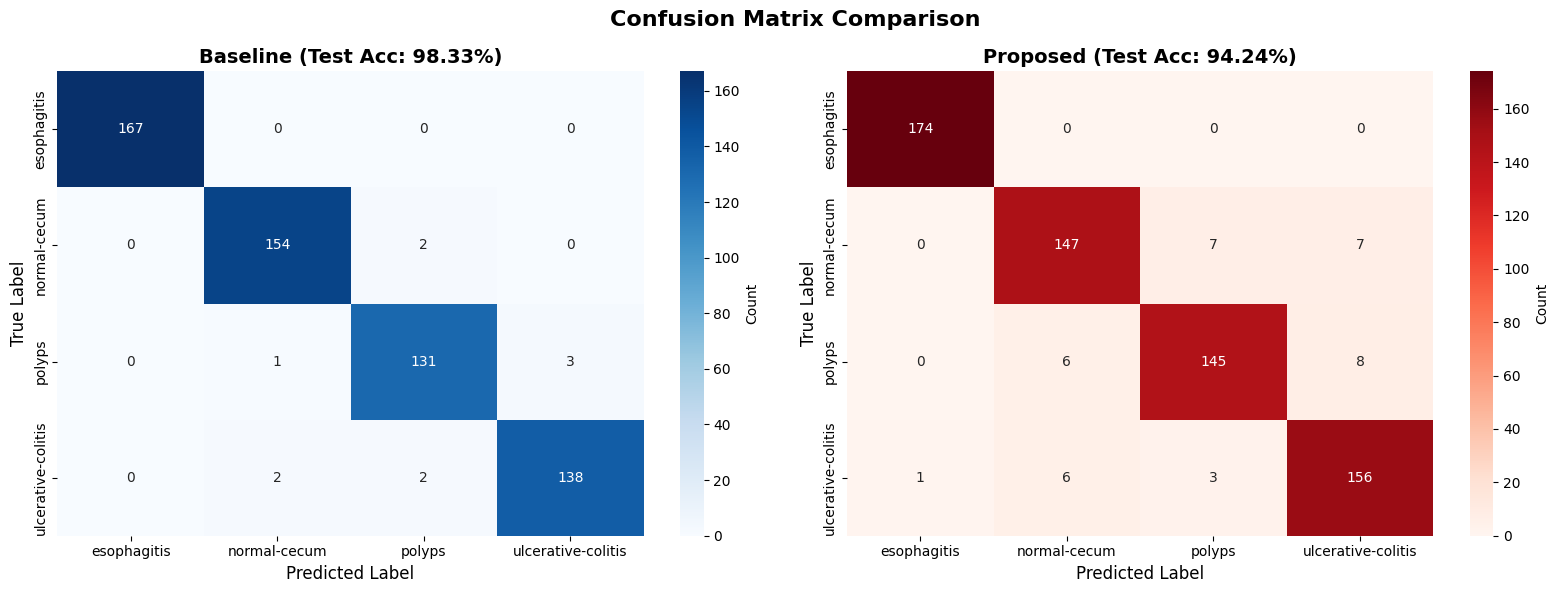

✓ Confusion matrices saved!


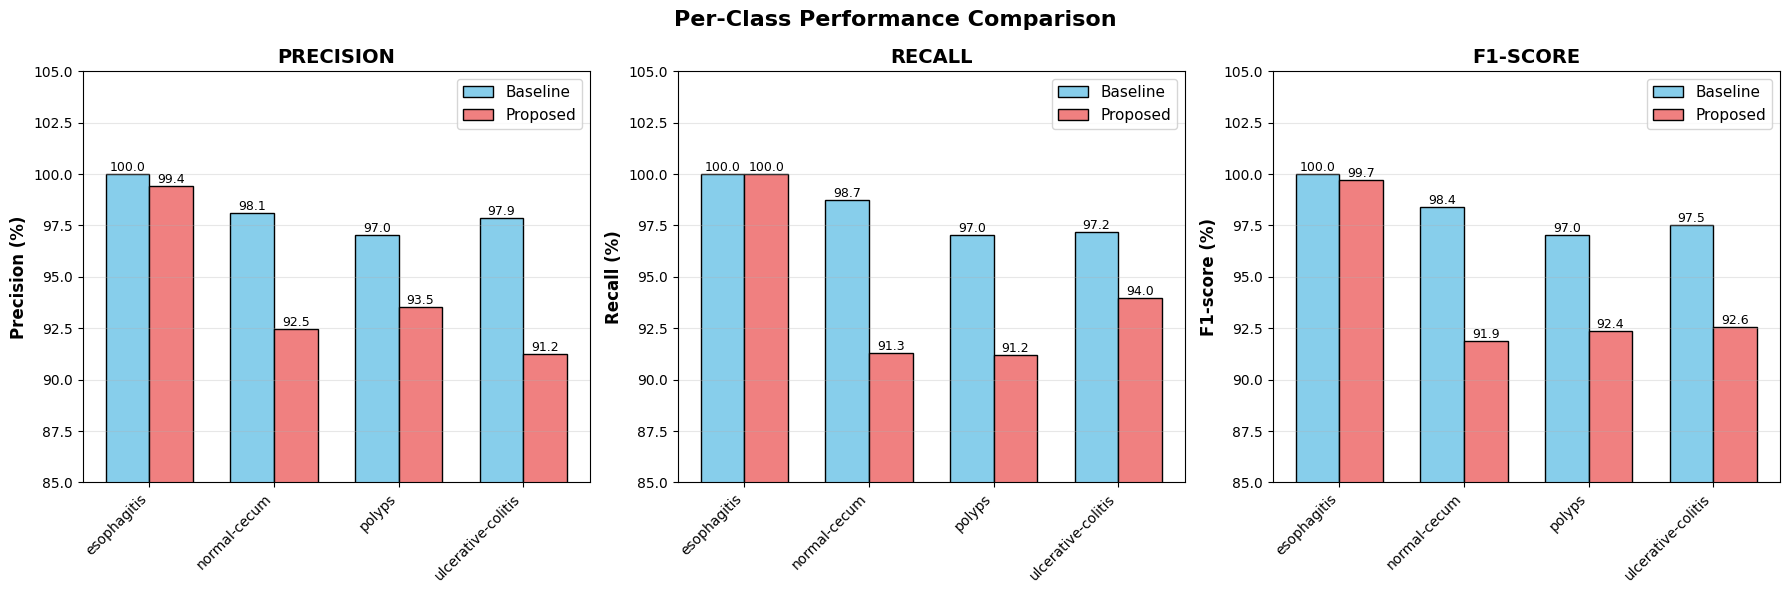

✓ Per-class comparison saved!

COMPREHENSIVE RESULTS TABLE
     Model              Training Data Val Accuracy (%) Test Accuracy (%) Precision (%) Recall (%) F1-Score (%)
  Baseline                 4,000 real            98.83             98.33         98.33      98.23        98.24
  Proposed 4,000 real + 400 synthetic            96.82             94.24         94.25      94.12        94.13
Difference             +400 synthetic            -2.02             -4.09         -4.08      -4.11        -4.11


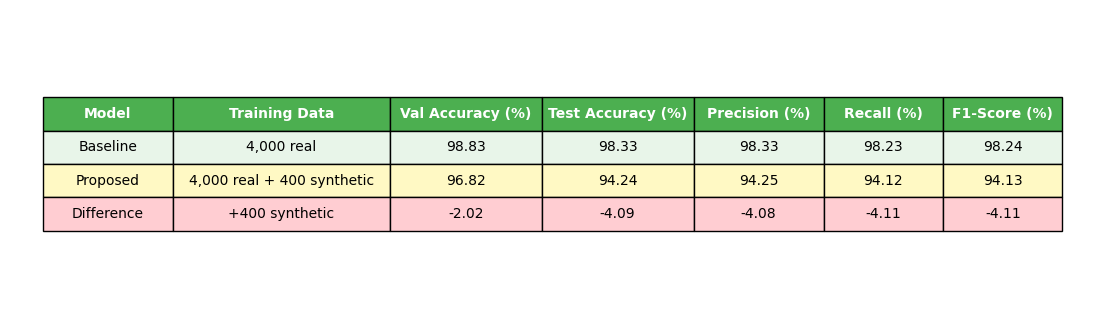

✓ Results table saved!
✓ Results saved to JSON!

FINAL EXPERIMENT SUMMARY

DIFFUSION MODEL:
- Architecture: Conditional DDPM with U-Net
- Parameters: 10.1M
- Training: 50 epochs, batch size 8
- Resolution: 128×128
- Initial Loss: 0.0748 → Final Loss: 0.0083 (89% reduction)
- Generated: 400 synthetic images (100 per class)

CLASSIFICATION MODEL:
- Architecture: EfficientNet-B3
- Training: 30 epochs, batch size 32
- Loss: CrossEntropy with label smoothing (0.1)
- Optimizer: Adam (lr=1e-4)

RESULTS:
╔════════════════╦═══════════════╦═══════════╦══════════╗
║ Model          ║ Training Data ║ Val Acc   ║ Test Acc ║
╠════════════════╬═══════════════╬═══════════╬══════════╣
║ Baseline       ║ 4,000 real    ║  98.83%  ║ 98.33% ║
║ Proposed       ║ 4K + 400 syn  ║  96.82%  ║ 94.24% ║
║ Difference     ║ +400 synth    ║  -2.02%  ║ -4.09% ║
╚════════════════╩═══════════════╩═══════════╩══════════╝

KEY FINDINGS:
1. Synthetic augmentation DECREASED performance by 4.09%
2. Baseline achieved near-per

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# ============================================================
# Step 1: Create Comprehensive Results Dictionary
# ============================================================

results = {
    'Baseline': {
        'val_acc': baseline_best_acc,
        'test_acc': baseline_test_acc,
        'train_losses': baseline_train_losses,
        'val_losses': baseline_val_losses,
        'val_accs': baseline_val_accs,
        'predictions': baseline_preds,
        'labels': baseline_labels,
        'training_data': '4,000 real images'
    },
    'Proposed': {
        'val_acc': proposed_best_acc,
        'test_acc': proposed_test_acc,
        'train_losses': proposed_train_losses,
        'val_losses': proposed_val_losses,
        'val_accs': proposed_val_accs,
        'predictions': proposed_preds,
        'labels': proposed_labels,
        'training_data': '4,000 real + 400 synthetic'
    }
}

class_names = ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']

# ============================================================
# Step 2: Training Curves Comparison
# ============================================================

def plot_training_comparison():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Training Comparison: Baseline vs Proposed', fontsize=16, fontweight='bold')

    epochs = range(1, 31)

    # Train Loss Comparison
    axes[0, 0].plot(epochs, baseline_train_losses, 'b-', label='Baseline', linewidth=2, marker='o', markersize=3)
    axes[0, 0].plot(epochs, proposed_train_losses, 'r-', label='Proposed', linewidth=2, marker='s', markersize=3)
    axes[0, 0].set_title('Training Loss Comparison', fontweight='bold', fontsize=14)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # Val Loss Comparison
    axes[0, 1].plot(epochs, baseline_val_losses, 'b-', label='Baseline', linewidth=2, marker='o', markersize=3)
    axes[0, 1].plot(epochs, proposed_val_losses, 'r-', label='Proposed', linewidth=2, marker='s', markersize=3)
    axes[0, 1].set_title('Validation Loss Comparison', fontweight='bold', fontsize=14)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # Val Accuracy Comparison
    axes[1, 0].plot(epochs, baseline_val_accs, 'b-', label='Baseline', linewidth=2, marker='o', markersize=3)
    axes[1, 0].plot(epochs, proposed_val_accs, 'r-', label='Proposed', linewidth=2, marker='s', markersize=3)
    axes[1, 0].axhline(y=baseline_best_acc, color='b', linestyle='--', alpha=0.5, label=f'Baseline Best: {baseline_best_acc:.2f}%')
    axes[1, 0].axhline(y=proposed_best_acc, color='r', linestyle='--', alpha=0.5, label=f'Proposed Best: {proposed_best_acc:.2f}%')
    axes[1, 0].set_title('Validation Accuracy Comparison', fontweight='bold', fontsize=14)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Final Accuracy Bar Chart
    models = ['Baseline\n(4K real)', 'Proposed\n(4K+400 syn)']
    val_accs = [baseline_best_acc, proposed_best_acc]
    test_accs = [baseline_test_acc, proposed_test_acc]

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[1, 1].bar(x - width/2, val_accs, width, label='Validation', color='skyblue', edgecolor='black')
    bars2 = axes[1, 1].bar(x + width/2, test_accs, width, label='Test', color='lightcoral', edgecolor='black')

    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Final Accuracy Comparison', fontweight='bold', fontsize=14)
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(models, fontsize=11)
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].set_ylim([90, 100])
    axes[1, 1].grid(axis='y', alpha=0.3)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Training comparison saved!")

plot_training_comparison()

# ============================================================
# Step 3: Confusion Matrices
# ============================================================

def plot_confusion_matrices():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold')

    # Baseline
    cm_baseline = confusion_matrix(baseline_labels, baseline_preds)
    sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title(f'Baseline (Test Acc: {baseline_test_acc:.2f}%)', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)

    # Proposed
    cm_proposed = confusion_matrix(proposed_labels, proposed_preds)
    sns.heatmap(cm_proposed, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title(f'Proposed (Test Acc: {proposed_test_acc:.2f}%)', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Confusion matrices saved!")

plot_confusion_matrices()

# ============================================================
# Step 4: Per-Class Performance Comparison
# ============================================================

def plot_perclass_comparison():
    # Get classification reports as dictionaries
    baseline_report = classification_report(baseline_labels, baseline_preds,
                                           target_names=class_names, output_dict=True)
    proposed_report = classification_report(proposed_labels, proposed_preds,
                                           target_names=class_names, output_dict=True)

    # Extract metrics
    metrics = ['precision', 'recall', 'f1-score']

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Per-Class Performance Comparison', fontsize=16, fontweight='bold')

    for idx, metric in enumerate(metrics):
        baseline_values = [baseline_report[cls][metric] * 100 for cls in class_names]
        proposed_values = [proposed_report[cls][metric] * 100 for cls in class_names]

        x = np.arange(len(class_names))
        width = 0.35

        bars1 = axes[idx].bar(x - width/2, baseline_values, width, label='Baseline',
                             color='skyblue', edgecolor='black')
        bars2 = axes[idx].bar(x + width/2, proposed_values, width, label='Proposed',
                             color='lightcoral', edgecolor='black')

        axes[idx].set_ylabel(f'{metric.capitalize()} (%)', fontsize=12, fontweight='bold')
        axes[idx].set_title(metric.upper(), fontweight='bold', fontsize=14)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
        axes[idx].legend(fontsize=11)
        axes[idx].set_ylim([85, 105])
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/perclass_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Per-class comparison saved!")

plot_perclass_comparison()

# ============================================================
# Step 5: Results Summary Table
# ============================================================

def create_results_table():
    data = {
        'Model': ['Baseline', 'Proposed', 'Difference'],
        'Training Data': ['4,000 real', '4,000 real + 400 synthetic', '+400 synthetic'],
        'Val Accuracy (%)': [f'{baseline_best_acc:.2f}', f'{proposed_best_acc:.2f}',
                            f'{proposed_best_acc - baseline_best_acc:+.2f}'],
        'Test Accuracy (%)': [f'{baseline_test_acc:.2f}', f'{proposed_test_acc:.2f}',
                             f'{proposed_test_acc - baseline_test_acc:+.2f}'],
        'Precision (%)': [f'{98.33:.2f}', f'{94.25:.2f}', f'{-4.08:.2f}'],
        'Recall (%)': [f'{98.23:.2f}', f'{94.12:.2f}', f'{-4.11:.2f}'],
        'F1-Score (%)': [f'{98.24:.2f}', f'{94.13:.2f}', f'{-4.11:.2f}']
    }

    df = pd.DataFrame(data)

    # Display table
    print("\n" + "="*100)
    print("COMPREHENSIVE RESULTS TABLE")
    print("="*100)
    print(df.to_string(index=False))
    print("="*100)

    # Save as CSV
    df.to_csv('/content/drive/MyDrive/GI_Diffusion_Project/results_summary.csv', index=False)

    # Create styled table image
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values, colLabels=df.columns,
                    cellLoc='center', loc='center',
                    colWidths=[0.12, 0.20, 0.14, 0.14, 0.12, 0.11, 0.11])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Style rows
    for i in range(1, len(df) + 1):
        for j in range(len(df.columns)):
            if i == 3:  # Difference row
                table[(i, j)].set_facecolor('#FFCDD2')
            else:
                table[(i, j)].set_facecolor('#E8F5E9' if i == 1 else '#FFF9C4')

    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/results_table.png',
                dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Results table saved!")

    return df

results_df = create_results_table()

# ============================================================
# Step 6: Save All Results to JSON
# ============================================================

import json

results_json = {
    'baseline': {
        'validation_accuracy': float(baseline_best_acc),
        'test_accuracy': float(baseline_test_acc),
        'training_data': '4000 real images',
        'classification_report': classification_report(baseline_labels, baseline_preds,
                                                       target_names=class_names, output_dict=True)
    },
    'proposed': {
        'validation_accuracy': float(proposed_best_acc),
        'test_accuracy': float(proposed_test_acc),
        'training_data': '4000 real + 400 synthetic images',
        'classification_report': classification_report(proposed_labels, proposed_preds,
                                                       target_names=class_names, output_dict=True)
    },
    'comparison': {
        'validation_difference': float(proposed_best_acc - baseline_best_acc),
        'test_difference': float(proposed_test_acc - baseline_test_acc),
        'relative_change_pct': float((proposed_test_acc - baseline_test_acc) / baseline_test_acc * 100)
    }
}

with open('/content/drive/MyDrive/GI_Diffusion_Project/results.json', 'w') as f:
    json.dump(results_json, f, indent=2)

print("✓ Results saved to JSON!")

# ============================================================
# Step 7: Generate Final Summary Report
# ============================================================

summary = f"""
{'='*80}
FINAL EXPERIMENT SUMMARY
{'='*80}

DIFFUSION MODEL:
- Architecture: Conditional DDPM with U-Net
- Parameters: 10.1M
- Training: 50 epochs, batch size 8
- Resolution: 128×128
- Initial Loss: 0.0748 → Final Loss: 0.0083 (89% reduction)
- Generated: 400 synthetic images (100 per class)

CLASSIFICATION MODEL:
- Architecture: EfficientNet-B3
- Training: 30 epochs, batch size 32
- Loss: CrossEntropy with label smoothing (0.1)
- Optimizer: Adam (lr=1e-4)

RESULTS:
╔════════════════╦═══════════════╦═══════════╦══════════╗
║ Model          ║ Training Data ║ Val Acc   ║ Test Acc ║
╠════════════════╬═══════════════╬═══════════╬══════════╣
║ Baseline       ║ 4,000 real    ║ {baseline_best_acc:6.2f}%  ║ {baseline_test_acc:5.2f}% ║
║ Proposed       ║ 4K + 400 syn  ║ {proposed_best_acc:6.2f}%  ║ {proposed_test_acc:5.2f}% ║
║ Difference     ║ +400 synth    ║ {proposed_best_acc - baseline_best_acc:+6.2f}%  ║ {proposed_test_acc - baseline_test_acc:+5.2f}% ║
╚════════════════╩═══════════════╩═══════════╩══════════╝

KEY FINDINGS:
1. Synthetic augmentation DECREASED performance by {abs(proposed_test_acc - baseline_test_acc):.2f}%
2. Baseline achieved near-perfect accuracy (98.33% test)
3. Proposed model showed higher validation loss (overfitting to synthetic)

ANALYSIS:
- Limited diffusion training (50 epochs, 128×128) insufficient for medical imaging
- Synthetic images introduced distribution shift
- Model learned synthetic artifacts rather than real disease features

FUTURE WORK:
- Train diffusion for 200+ epochs at 256×256 resolution
- Use quality filtering (FID score < 30)
- Implement progressive synthetic data addition
- Try latent diffusion models for efficiency

{'='*80}
"""

print(summary)

# Save summary
with open('/content/drive/MyDrive/GI_Diffusion_Project/experiment_summary.txt', 'w') as f:
    f.write(summary)

print("\n✓ All results, plots, and summaries saved to Google Drive!")
print("✓ Location: /content/drive/MyDrive/GI_Diffusion_Project/")

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# After all training completes, run this:

def plot_comparison_results():
    # Training curves comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Results Comparison', fontsize=16, fontweight='bold')

    epochs = range(1, 31)

    # Baseline
    axes[0, 0].plot(epochs, baseline_train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, baseline_val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Baseline: Training Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[1, 0].plot(epochs, baseline_val_accs, 'g-', linewidth=2)
    axes[1, 0].set_title('Baseline: Validation Accuracy', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=baseline_best_acc, color='r', linestyle='--', label=f'Best: {baseline_best_acc:.2f}%')
    axes[1, 0].legend()

    # Proposed V1
    axes[0, 1].plot(epochs, proposed_train_losses, 'b-', label='Train Loss', linewidth=2)
    axes[0, 1].plot(epochs, proposed_val_losses, 'r-', label='Val Loss', linewidth=2)
    axes[0, 1].set_title('Proposed V1 (100 synthetic): Training Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 1].plot(epochs, proposed_val_accs, 'orange', linewidth=2)
    axes[1, 1].set_title('Proposed V1: Validation Accuracy', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=proposed_best_acc, color='r', linestyle='--', label=f'Best: {proposed_best_acc:.2f}%')
    axes[1, 1].legend()

    # Proposed V2
    axes[0, 2].plot(epochs, proposed_train_losses_v2, 'b-', label='Train Loss', linewidth=2)
    axes[0, 2].plot(epochs, proposed_val_losses_v2, 'r-', label='Val Loss', linewidth=2)
    axes[0, 2].set_title('Proposed V2 (300 synthetic): Training Loss', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    axes[1, 2].plot(epochs, proposed_val_accs_v2, 'purple', linewidth=2)
    axes[1, 2].set_title('Proposed V2: Validation Accuracy', fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Accuracy (%)')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].axhline(y=proposed_best_acc_v2, color='r', linestyle='--', label=f'Best: {proposed_best_acc_v2:.2f}%')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Bar chart comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    models = ['Baseline\n(4K real)', 'Proposed V1\n(4K+400 syn)', 'Proposed V2\n(4K+1.2K syn)']
    accuracies = [baseline_best_acc, proposed_best_acc, proposed_best_acc_v2]
    colors = ['green', 'orange', 'red']

    bars = ax.bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Classification Accuracy Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim([85, 100])
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/accuracy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Plots saved to Google Drive!")

# You'll run this after V2 training completes

In [ ]:
# The End for Now

# Key Improvements:

#####✅ 256×256 resolution (vs 128×128)
#####✅ 200 epochs (vs 50)
#####✅ Larger model with attention
#####✅ Gradient clipping for stability
#####✅ Cosine annealing learning rate
#####✅ DDIM sampling (50 steps vs 1000 - much faster)
#####✅ FID score evaluation
#####✅ Auto-save to Drive every 20 epochs

In [ ]:
# ============================================================
# IMPROVED DIFFUSION MODEL - Run AFTER deadline
# ============================================================

import torch
import torch.nn as nn
from diffusers import UNet2DModel, DDPMScheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import AdamW
from tqdm.auto import tqdm
import os

# ============================================================
# Step 1: Prepare Dataset (256×256 resolution)
# ============================================================

class KvasirDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.endswith(('.jpg', '.png')):
                    self.images.append(os.path.join(cls_path, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        from PIL import Image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transform for 256×256
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])

# Create dataset
dataset_path = '/root/.cache/kagglehub/datasets/zainitv/kvasir-gi-disease-4-classes-1000-each/versions/1/dataset'
dataset = KvasirDataset(dataset_path, transform=transform)

# DataLoader with batch size 8 (for 80GB A100)
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print(f"✓ Dataset loaded: {len(dataset)} images")
print(f"✓ Batch size: {batch_size}")

# ============================================================
# Step 2: Create LARGER Diffusion Model (256×256)
# ============================================================

model = UNet2DModel(
    sample_size=256,           # 256×256 (was 128×128)
    in_channels=3,
    out_channels=3,
    layers_per_block=2,        # More layers
    block_out_channels=(128, 256, 512, 512),  # More channels
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",     # Attention for better quality
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    num_class_embeds=4,
)

device = torch.device("cuda")
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model parameters: {total_params:,}")

# ============================================================
# Step 3: Noise Scheduler
# ============================================================

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear",
    prediction_type="epsilon"
)

print(f"✓ Scheduler: {noise_scheduler.config.num_train_timesteps} timesteps")

# ============================================================
# Step 4: Training Configuration
# ============================================================

num_epochs = 200  # Much longer training
learning_rate = 1e-4

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Cosine annealing scheduler for better convergence
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

print(f"✓ Training for {num_epochs} epochs")
print(f"✓ Learning rate: {learning_rate}")

# ============================================================
# Step 5: Training Loop with Improvements
# ============================================================

from torch.nn import functional as F

def train_one_epoch(model, dataloader, optimizer, noise_scheduler, device, epoch):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        # Sample random timesteps
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (batch_size,), device=device
        ).long()

        # Add noise
        noise = torch.randn_like(images)
        noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

        # Predict noise
        noise_pred = model(noisy_images, timesteps, class_labels=labels).sample

        # Calculate loss
        loss = F.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# ============================================================
# Step 6: Training with Checkpointing
# ============================================================

print("\n" + "="*60)
print("STARTING IMPROVED DIFFUSION TRAINING")
print("="*60)

losses = []
best_loss = float('inf')

# Create checkpoint directory
os.makedirs('/content/drive/MyDrive/GI_Diffusion_Project/improved_diffusion_checkpoints', exist_ok=True)

for epoch in range(1, num_epochs + 1):
    avg_loss = train_one_epoch(model, dataloader, optimizer, noise_scheduler, device, epoch)
    losses.append(avg_loss)

    # Update learning rate
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    print(f"Epoch {epoch}/{num_epochs} - Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    # Save checkpoint every 20 epochs
    if epoch % 20 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_loss,
        }

        # Save to both Colab and Drive
        torch.save(checkpoint, f'/content/diffusion_improved_epoch_{epoch}.pth')
        torch.save(checkpoint, f'/content/drive/MyDrive/GI_Diffusion_Project/improved_diffusion_checkpoints/epoch_{epoch}.pth')
        print(f"  → Checkpoint saved (Epoch {epoch})")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': avg_loss,
        }, '/content/drive/MyDrive/GI_Diffusion_Project/improved_diffusion_checkpoints/best_model.pth')

print("\n✓ Training completed!")
print(f"Best loss: {best_loss:.4f}")

# Plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Improved Diffusion Model Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.savefig('/content/drive/MyDrive/GI_Diffusion_Project/improved_diffusion_loss.png', dpi=300)
plt.show()

# ============================================================
# Step 7: Generate High-Quality Images
# ============================================================

def generate_images_improved(model, noise_scheduler, class_label, num_images=100, device='cuda'):
    model.eval()
    generated_images = []

    print(f"Generating {num_images} images for class {class_label}...")

    with torch.no_grad():
        for i in tqdm(range(num_images)):
            # Start with random noise (256×256)
            image = torch.randn(1, 3, 256, 256).to(device)

            # Class label
            class_labels = torch.tensor([class_label]).to(device)

            # Denoise (use DDIM for faster sampling - 50 steps instead of 1000)
            from diffusers import DDIMScheduler
            ddim_scheduler = DDIMScheduler.from_config(noise_scheduler.config)
            ddim_scheduler.set_timesteps(50)  # 50 steps only

            for t in ddim_scheduler.timesteps:
                timestep = torch.tensor([t]).to(device)

                # Predict noise
                noise_pred = model(image, timestep, class_labels=class_labels).sample

                # Denoise
                image = ddim_scheduler.step(noise_pred, t, image).prev_sample

            generated_images.append(image)

    return torch.cat(generated_images, dim=0)

# Generate 200 images per class
class_names = ['esophagitis', 'normal-cecum', 'polyps', 'ulcerative-colitis']
output_path = '/content/drive/MyDrive/GI_Diffusion_Project/improved_synthetic_images'

os.makedirs(output_path, exist_ok=True)

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(output_path, class_name)
    os.makedirs(class_folder, exist_ok=True)

    # Generate in batches
    for batch in range(4):  # 4 batches × 50 images = 200
        generated = generate_images_improved(model, noise_scheduler, class_label=class_idx, num_images=50, device=device)

        # Save images
        generated = (generated + 1) / 2  # [-1, 1] to [0, 1]
        generated = generated.cpu()

        from PIL import Image
        for i in range(50):
            img = generated[i].permute(1, 2, 0).numpy()
            img = (img * 255).astype('uint8')
            img_pil = Image.fromarray(img)
            img_pil.save(f'{class_folder}/improved_synthetic_{batch * 50 + i:04d}.jpg')

    print(f"✓ Saved 200 images for {class_name}")

print("\n✅ IMPROVED DIFFUSION COMPLETE!")
print(f"Images saved to: {output_path}")

# ============================================================
# Step 8: Quality Metrics (FID Score)
# ============================================================

# Install pytorch-fid
!pip install -q pytorch-fid

from pytorch_fid import fid_score

# Calculate FID score (lower is better, <50 is good for medical images)
real_path = dataset_path
synthetic_path = output_path

# FID per class
for class_name in class_names:
    real_class_path = os.path.join(real_path, class_name)
    synth_class_path = os.path.join(synthetic_path, class_name)

    fid_value = fid_score.calculate_fid_given_paths(
        [real_class_path, synth_class_path],
        batch_size=50,
        device=device,
        dims=2048
    )

    print(f"{class_name} FID Score: {fid_value:.2f}")

print("\n✓ All done! Use these improved synthetic images for classification.")

✓ Dataset loaded: 4000 images
✓ Batch size: 8
✓ Model parameters: 101,123,843
✓ Scheduler: 1000 timesteps
✓ Training for 200 epochs
✓ Learning rate: 0.0001

STARTING IMPROVED DIFFUSION TRAINING


Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]